## Utils

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import v_measure_score
from typing import Dict, Any, Optional
import os
import pathlib

class ClusteringMetrics:
    """Evaluate clustering vs. ground‑truth phrase labels."""

    # ─────────────────────────────── core ────────────────────────────────
    def __init__(self, gt: np.ndarray, pred: np.ndarray, silence: int = 0):
        if gt.shape != pred.shape:
            raise ValueError("gt and pred arrays must have identical shape")
        self.gt_raw = gt.astype(int)
        self.pred = pred.astype(int)
        self.gt = self._merge_silence(self.gt_raw, silence)

        self.gt_types = np.unique(self.gt)
        self.pred_types = np.unique(self.pred)

        self._build_confusion()
        self.mapping = self._hungarian()

    # ------------------------------ helpers ------------------------------
    @staticmethod
    def _merge_silence(arr: np.ndarray, silence: int) -> np.ndarray:
        """Fill contiguous *silence* runs with the nearest neighbour label."""
        if arr.size == 0:
            return arr
        out = arr.copy()
        i = 0
        while i < len(out):
            if out[i] != silence:
                i += 1
                continue
            j = i
            while j < len(out) and out[j] == silence:
                j += 1
            left = out[i - 1] if i else None
            right = out[j] if j < len(out) else None
            fill = right if left is None else left if right is None else left
            out[i:j] = fill
            i = j
        return out

    def _build_confusion(self) -> None:
        """GT×Pred frame counts + column‑normalised version."""
        gt_idx = {l: i for i, l in enumerate(self.gt_types)}
        pr_idx = {l: i for i, l in enumerate(self.pred_types)}
        self.C = np.zeros((len(self.gt_types), len(self.pred_types)), int)
        for g, p in zip(self.gt, self.pred):
            np.add.at(self.C, (gt_idx[g], pr_idx[p]), 1)
        col_sum = self.C.sum(0, keepdims=True)
        self.C_norm = np.divide(self.C, col_sum, where=col_sum != 0)

    def _hungarian(self) -> Dict[int, int]:
        if self.C_norm.size == 0:
            return {}
        row, col = linear_sum_assignment(-self.C_norm)
        return {self.gt_types[r]: self.pred_types[c] for r, c in zip(row, col)}

    # ------------------------------ metrics ------------------------------
    def v_measure(self) -> float:
        return 1.0 if self.gt.size == 0 else v_measure_score(self.gt, self.pred)

    def frame_error_rate(self) -> float:
        if self.gt.size == 0:
            return 0.0
        correct = np.vectorize(lambda g, p: p == self.mapping.get(g, None))(self.gt, self.pred)
        return 100 * (1 - correct.mean())

    def macro_fer(self) -> float:
        if self.gt_types.size == 0:
            return 0.0
        fer = []
        for g in self.gt_types:
            idx = self.gt == g
            fer.append(1.0 if g not in self.mapping else (self.pred[idx] != self.mapping[g]).mean())
        return 100 * np.mean(fer)

    def stats(self) -> Dict[str, Any]:
        counts = {g: (self.gt == g).sum() for g in self.gt_types}
        mapped = set(self.mapping)
        mapped_frames = sum(v for k, v in counts.items() if k in mapped)
        total = self.gt.size
        return dict(
            pct_types_mapped=100 * len(mapped) / len(self.gt_types) if self.gt_types.size else 0,
            pct_frames_mapped=100 * mapped_frames / total if total else 0,
            mapped_counts={k: v for k, v in counts.items() if k in mapped},
            unmapped_counts={k: v for k, v in counts.items() if k not in mapped},
        )

    # ────────────────────────────── plotting ──────────────────────────────
    def plot(self, title: str = "HDBSCAN Clustering Evaluation", figsize=(18, 10)) -> plt.Figure:
        st = self.stats()
        fig = plt.figure(figsize=figsize)
        gs = GridSpec(2, 3, figure=fig, height_ratios=[1, 1.2])

        def _annot_bar(ax, data, color, ttl):
            if not data:
                ax.set_axis_off()
                return
            labels, vals = zip(*data.items())
            perc = 100 * np.array(vals) / self.gt.size
            bars = ax.bar(labels, perc, color=color)
            for b, v_val in zip(bars, perc): # Renamed v to v_val to avoid conflict
                if v_val > .5:
                    ax.text(b.get_x() + b.get_width() / 2, v_val + .3, f"{v_val:.1f}%", ha="center", va="bottom", fontsize=7)
            ax.set_title(ttl)
            ax.set_ylabel("% frames")
            ax.tick_params(axis="x", rotation=45, labelsize=8)

        # summary box
        ax0 = fig.add_subplot(gs[0, 0]); ax0.axis("off")
        txt = (
            f"Overall FER : {self.frame_error_rate():.1f}%\n"
            f"Macro FER   : {self.macro_fer():.1f}%\n"
            f"V‑measure   : {self.v_measure():.3f}\n\n"
            f"GT types    : {len(self.gt_types)}\n"
            f"Pred types  : {len(self.pred_types)}\n"
            f"Mapped types: {st['pct_types_mapped']:.1f}%"
        )
        ax0.text(0, 1, txt, va="top", fontsize=10, bbox=dict(fc="whitesmoke", alpha=.8))

        # pies
        ax1 = fig.add_subplot(gs[0, 1])
        ax1.pie([st['pct_types_mapped'], 100 - st['pct_types_mapped']], labels=["mapped", "unmapped"],
                 autopct="%.1f%%", colors=["#8fd175", "#f28e8e"])
        ax1.set_title("GT label types")

        ax2 = fig.add_subplot(gs[0, 2])
        ax2.pie([st['pct_frames_mapped'], 100 - st['pct_frames_mapped']], labels=["mapped", "unmapped"],
                 autopct="%.1f%%", colors=["#71b3ff", "#ffb471"])
        ax2.set_title("GT frames")

        # bars
        ax3 = fig.add_subplot(gs[1, 0:2])
        _annot_bar(ax3, st['mapped_counts'], "#4daf4a", "Mapped GT labels")
        ax4 = fig.add_subplot(gs[1, 2])
        _annot_bar(ax4, st['unmapped_counts'], "#d73027", "Unmapped GT labels")

        fig.suptitle(title, fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.96])
        return fig


# ────────────────────────── convenience wrapper ──────────────────────────

def comprehensive_report(
    ground_truth: np.ndarray,
    predicted_labels: np.ndarray,
    show: bool = True,
    save_path: Optional[str] = None,
):
    """Shortcut: build metrics + figure in one call."""
    cm = ClusteringMetrics(ground_truth, predicted_labels)
    fig = cm.plot()
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)
    return cm

def full_evaluation(
    embedding: np.ndarray,
    gt_labels: np.ndarray,
    cluster_labels: np.ndarray,
    output_dir: str | os.PathLike,
    *,
    umap_figsize: tuple[int, int] = (10, 5),
) -> ClusteringMetrics:
    """Save UMAP overlays + metrics dashboard + summary text file into *output_dir*.

    Parameters
    ----------
    embedding      : (N, 2) array of 2‑D coords (from UMAP or alike)
    gt_labels      : (N,) ground‑truth labels (ints)
    cluster_labels : (N,) cluster assignments (ints, ‑1 = noise)
    output_dir     : destination folder (created if absent)
    umap_figsize   : size of the UMAP figure

    Returns
    -------
    `ClusteringMetrics` instance for further inspection.
    """
    path = pathlib.Path(output_dir)
    path.mkdir(parents=True, exist_ok=True)

    # 1. scatter overlays
    fig_umap, axes = plt.subplots(1, 2, figsize=umap_figsize)
    axes[0].scatter(embedding[:, 0], embedding[:, 1], c=gt_labels, cmap="tab20", alpha=0.1, s=1)
    axes[0].set_title("Ground Truth")
    axes[1].scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap="tab20", alpha=0.1, s=1)
    axes[1].set_title("HDBSCAN")
    fig_umap.tight_layout()
    umap_path = path / "umap_gt_vs_cluster.png"
    fig_umap.savefig(umap_path, dpi=150, bbox_inches="tight")
    plt.close(fig_umap)

    # 2. metrics dashboard
    report_path = path / "clustering_report.png"
    # We need the cm object from comprehensive_report, or call ClusteringMetrics directly
    # Re-using comprehensive_report means it will try to show/close the plot,
    # so it's better to instantiate ClusteringMetrics directly here.

    cm = ClusteringMetrics(gt_labels, cluster_labels)
    fig_report = cm.plot() # Get the figure object
    fig_report.savefig(report_path, dpi=150, bbox_inches="tight")
    plt.close(fig_report) # Close the plot as we've saved it

    # 3. Save summary metrics to a text file
    metrics_summary_path = path / "summary_metrics.txt"
    stats_data = cm.stats()
    with open(metrics_summary_path, "w") as f:
        f.write(f"Overall FER: {cm.frame_error_rate():.1f}%\n")
        f.write(f"Macro FER: {cm.macro_fer():.1f}%\n")
        f.write(f"V-measure: {cm.v_measure():.3f}\n")
        f.write(f"Percentage of GT types mapped: {stats_data['pct_types_mapped']:.1f}%\n")
        f.write(f"Percentage of GT frames mapped: {stats_data['pct_frames_mapped']:.1f}%\n")

    print(f"saved: {umap_path}\nsaved: {report_path}\nsaved: {metrics_summary_path}")
    return cm

## Load Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

f = np.load("/Users/georgev/Downloads/llb16_raw_false.npz")

embedding = f["embedding_outputs"]
neural_states = f["predictions"]
ground_truth = f["ground_truth_labels"]
hdbscan_labels = f["hdbscan_labels"]

# count unique labels in ground truth
print(np.unique(ground_truth, return_counts=True))

# Make all arrays divisible by 3 by dropping the last few points if needed
N = embedding.shape[0]
N_div3 = (N // 3) * 3  # largest multiple of 3 less than or equal to N

embedding = embedding[:N_div3]
neural_states = neural_states[:N_div3]
ground_truth = ground_truth[:N_div3]
hdbscan_labels = hdbscan_labels[:N_div3]

embedding_folds = np.split(embedding, 3)
neural_states_folds = np.split(neural_states, 3)
ground_truth_folds = np.split(ground_truth, 3)
hdbscan_labels_folds = np.split(hdbscan_labels, 3)

# print shapes of all 4 arrays post fold
print(f"Embedding folds shapes: {[fold.shape for fold in embedding_folds]}")
print(f"Neural States folds shapes: {[fold.shape for fold in neural_states_folds]}")
print(f"Ground Truth folds shapes: {[fold.shape for fold in ground_truth_folds]}")
print(f"HDBSCAN Labels folds shapes: {[fold.shape for fold in hdbscan_labels_folds]}")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]), array([390610,  46887,  34722,   6689, 122818,   7533,  22950,  47902,
        68702,  21937,  47574,  10394,  15658,  36030,   1407,   8047,
         3355,   2866,   2518,   6216,   2440,   1429,   1151,   1806,
         1486,   7089,   8000,  11889,   5825,  55527,   1009]))
Embedding folds shapes: [(334155, 2), (334155, 2), (334155, 2)]
Neural States folds shapes: [(334155, 196), (334155, 196), (334155, 196)]
Ground Truth folds shapes: [(334155,), (334155,), (334155,)]
HDBSCAN Labels folds shapes: [(334155,), (334155,), (334155,)]


## Original UMAP HDBSCAN Analysis

In [ ]:
for i in range(3):
    full_evaluation(embedding=embedding_folds[i], gt_labels=ground_truth_folds[i], cluster_labels=hdbscan_labels_folds[i], output_dir=f"/Users/georgev/Documents/codebases/parametric_umap/umap_sweeps/fold_original_umap{i}")

## Calculate UMAPs and save them for 30 Neigbors and min dist 0 w different distance metrics, 2 and 6 dimensions

In [ ]:
import numpy as np
import umap
from pathlib import Path
import matplotlib.pyplot as plt

X  = embedding_folds
ns = neural_states_folds
gt = ground_truth_folds
cl = hdbscan_labels_folds

# metrics to run
metrics = [
    "cosine",
    "euclidean",   # commented out for now
    "correlation",
]

dims  = [2, 6]
out   = Path("/Users/georgev/Documents/codebases/parametric_umap/embeddings/first_pass")
out.mkdir(parents=True, exist_ok=True)

# --- 3. sweep metrics & dims ---
for fold_idx in (1,2,3):
    for m in metrics:
        print(f"\nfold {fold_idx} · metric = {m}")
        for d in dims:
            print(f"  computing {d}d embedding… shape {ns[fold_idx - 1].shape}", end="", flush=True)

            um = umap.UMAP(
                n_neighbors = 30,
                min_dist    = 0.0,
                n_components= d,
                metric      = m,
                n_epochs    = 200,
                n_jobs      = -1,
                low_memory  = True,
                verbose     = False,
            )
            emb = um.fit_transform(ns[fold_idx - 1])

            fname   = out / f"umap_fold{fold_idx}_{m}_{d}d.npz"
            np.savez_compressed(
                fname,
                embedding      = emb,
                neural_states  = ns[fold_idx - 1],
                ground_truth   = gt[fold_idx - 1]
            )
            print(f" done → {fname.name}")

## HDBSCAN Analysis

In [ ]:
import hdbscan

umap_dirs = "/Users/georgev/Documents/codebases/parametric_umap/embeddings/first_pass"

min_samples = 1 
min_cluster_size = [50,500,5000]

for file in os.listdir(umap_dirs):
    if file.endswith(".npz"):
        data = np.load(os.path.join(umap_dirs, file))
        embedding = data["embedding"]
        print(embedding.shape)
        ground_truth = data["ground_truth"]

        # get filename
        filename = file.split(".")[0]

        # perform HDBSCAN with min_cluster_size = 50, 500, 5000
        for min_cluster_size in [50, 500, 5000]:
            hdbscan_labels = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples).fit_predict(embedding)

            dim = filename.split("_")[-1]
            
            if dim == "6d":
                two_d_embedding_filename = filename.replace("6d", "2d")
                two_d_embedding_data = np.load(f"/Users/georgev/Documents/codebases/parametric_umap/embeddings/first_pass/{two_d_embedding_filename}.npz")
                two_d_embedding = two_d_embedding_data["embedding"]

                hdbscan_labels = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples).fit_predict(embedding)
                full_evaluation(embedding=two_d_embedding, gt_labels=ground_truth, cluster_labels=hdbscan_labels, output_dir=f"/Users/georgev/Documents/codebases/parametric_umap/umap_sweeps/{filename}_{min_cluster_size}")

            else:
                hdbscan_labels = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples).fit_predict(embedding)
                full_evaluation(embedding=embedding, gt_labels=ground_truth, cluster_labels=hdbscan_labels, output_dir=f"/Users/georgev/Documents/codebases/parametric_umap/umap_sweeps/{filename}_{min_cluster_size}")


/Users/georgev/anaconda3/envs/tweetybert/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgev/anaconda3/envs/tweetybert/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


real samples: 334155, max class size: 75817


/Users/georgev/anaconda3/envs/tweetybert/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgev/anaconda3/envs/tweetybert/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgev/anaconda3/envs/tweetybert/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


saved: /Users/georgev/Documents/codebases/parametric_umap/umap_sweeps/SMOTE_subset/umap_gt_vs_cluster.png
saved: /Users/georgev/Documents/codebases/parametric_umap/umap_sweeps/SMOTE_subset/clustering_report.png
saved: /Users/georgev/Documents/codebases/parametric_umap/umap_sweeps/SMOTE_subset/summary_metrics.txt


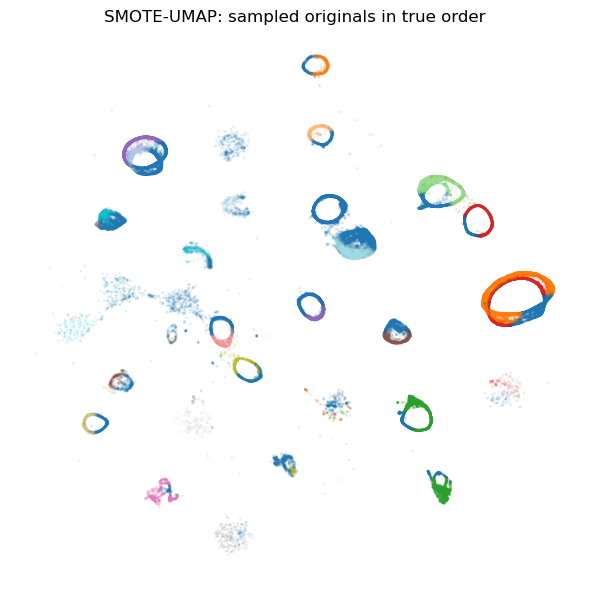

In [11]:
# %%
import numpy as np
import umap
import hdbscan

# %%
# load embeddings and initial clustering
f = np.load("/Users/georgev/Documents/codebases/parametric_umap/embeddings/first_pass/umap_fold3_cosine_6d.npz")
embedding_init = f["embedding"]
X = f["neural_states"]
y_true = f["ground_truth"]
n_real = X.shape[0]
rng = np.random.default_rng(42)

hdb_init_labels = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1).fit_predict(embedding_init)
unique_labels = np.unique(hdb_init_labels)
class_counts = {lbl: np.sum(hdb_init_labels == lbl) for lbl in unique_labels}
max_size = max(class_counts.values())
print(f"real samples: {n_real}, max class size: {max_size}")

# %%
# SMOTE-style oversampling
X_aug = [X]
y_aug = [y_true]
for lbl, cnt in class_counts.items():
    n_to_gen = max_size - cnt
    if n_to_gen <= 0:
        continue
    X_cls = X[hdb_init_labels == lbl]
    y_cls = y_true[hdb_init_labels == lbl]
    for _ in range(n_to_gen):
        i1, i2 = rng.choice(len(X_cls), size=2, replace=False)
        alpha = rng.random()
        new_pt = X_cls[i1] + alpha * (X_cls[i2] - X_cls[i1])
        X_aug.append(new_pt[None, :])
        y_aug.append(np.array([y_cls[i1]]))
X_aug = np.vstack(X_aug)
y_aug = np.concatenate(y_aug)

# %%
# sample subset of originals and synthetic for tighter UMAP
n_total = len(X_aug)
n_smote = n_total - n_real
n_sub_orig = 100_000
n_sub_smote = 300_000

orig_idx = rng.choice(n_real, size=min(n_sub_orig, n_real), replace=False)
smote_idx = rng.choice(n_smote, size=min(n_sub_smote, n_smote), replace=False) + n_real
subset_idx = np.concatenate([orig_idx, smote_idx])
X_subset = X_aug[subset_idx]

# %%
# fit & transform UMAP on the subset only
u = umap.UMAP(n_neighbors=30, min_dist=0, metric="cosine", low_memory=True)
coords_sub = u.fit_transform(X_subset)

# %%
# extract and sort original-point embeddings to match y_true order
mask_orig = subset_idx < n_real
coords_orig_sub = coords_sub[mask_orig]
orig_sub_indices = subset_idx[mask_orig]
order = np.argsort(orig_sub_indices)
coords_orig_sorted = coords_orig_sub[order]
y_true_sub = y_true[orig_sub_indices[order]]

# %%
# recluster and evaluate on the original subset
new_hdb_labels_sub = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1).fit_predict(coords_orig_sorted)

full_evaluation(
    embedding=coords_orig_sorted,
    gt_labels=y_true_sub,
    cluster_labels=new_hdb_labels_sub,
    output_dir="/Users/georgev/Documents/codebases/parametric_umap/umap_sweeps/SMOTE_subset"
)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(coords_orig_sorted[:, 0], coords_orig_sorted[:, 1],
           c=y_true_sub, cmap="tab20", s=1, alpha=0.08)
ax.set_title("SMOTE-UMAP: sampled originals in true order")
ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# %%
import numpy as np
import umap
import hdbscan
# %%
# load embeddings and initial clustering
f = np.load("/Users/georgev/Documents/codebases/parametric_umap/embeddings/first_pass/umap_fold3_correlation_6d.npz")
embedding_init = f["embedding"]
X = f["neural_states"]
y_true = f["ground_truth"]
n_real = X.shape[0]
rng = np.random.default_rng(42)
hdb_init_labels = hdbscan.HDBSCAN(min_cluster_size=500, min_samples=1).fit_predict(embedding_init)
unique_labels = np.unique(hdb_init_labels)
class_counts = {lbl: np.sum(hdb_init_labels == lbl) for lbl in unique_labels}
max_size = max(class_counts.values())
print(f"real samples: {n_real}, max class size: {max_size}")
# %%
# SMOTE-style oversampling
X_aug = [X]
y_aug = [y_true]
for lbl, cnt in class_counts.items():
    n_to_gen = max_size - cnt
    if n_to_gen <= 0:
        continue
    X_cls = X[hdb_init_labels == lbl]
    y_cls = y_true[hdb_init_labels == lbl]
    for _ in range(n_to_gen):
        i1, i2 = rng.choice(len(X_cls), size=2, replace=False)
        alpha = rng.random()
        new_pt = X_cls[i1] + alpha * (X_cls[i2] - X_cls[i1])
        X_aug.append(new_pt[None, :])
        y_aug.append(np.array([y_cls[i1]]))
X_aug = np.vstack(X_aug)
y_aug = np.concatenate(y_aug)
# %%
# sample subset of originals and synthetic for tighter UMAP
n_total = len(X_aug)
n_smote = n_total - n_real
n_sub_orig = 300_000
n_sub_smote = 300_000
orig_idx = rng.choice(n_real, size=min(n_sub_orig, n_real), replace=False)
smote_idx = rng.choice(n_smote, size=min(n_sub_smote, n_smote), replace=False) + n_real
subset_idx = np.concatenate([orig_idx, smote_idx])
X_subset = X_aug[subset_idx]
# %%
# fit & transform UMAP on the subset only
u = umap.UMAP(n_neighbors=30, min_dist=0, metric="cosine", low_memory=True)
coords_sub = u.fit_transform(X_subset)
# %%
# extract and sort original-point embeddings to match y_true order
mask_orig = subset_idx < n_real
coords_orig_sub = coords_sub[mask_orig]
orig_sub_indices = subset_idx[mask_orig]
order = np.argsort(orig_sub_indices)
coords_orig_sorted = coords_orig_sub[order]
y_true_sub = y_true[orig_sub_indices[order]]
# %%
# recluster and evaluate on the original subset
new_hdb_labels_sub = hdbscan.HDBSCAN(min_cluster_size=500, min_samples=1).fit_predict(coords_orig_sorted)
full_evaluation(
    embedding=coords_orig_sorted,
    gt_labels=y_true_sub,
    cluster_labels=new_hdb_labels_sub,
    output_dir="/Users/georgev/Documents/codebases/parametric_umap/umap_sweeps/SMOTE_subset"
)
# %%
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(coords_orig_sorted[:, 0], coords_orig_sorted[:, 1],
           c=y_true_sub, cmap="tab20", s=1, alpha=0.08)
ax.set_title("SMOTE-UMAP: sampled originals in true order")
ax.axis("off")
plt.tight_layout()
plt.show()